In [52]:
import sidecar
import ipyleaflet
import datacube

In [53]:
dc = datacube.Datacube()

In [54]:
data = dc.load(product='ga_ls8c_ard_3', 
               lat=(-35, -36), lon=(148, 149),
               time='2018-01-01',
               group_by='solar_day',
               resolution=(30,30),
               output_crs='epsg:3577',
               dask_chunks={'time': 1, 'x': 2000, 'y': 2000})

In [55]:
from datacube.storage.masking import mask_invalid_data

In [56]:
blue = mask_invalid_data(data.nbar_blue)

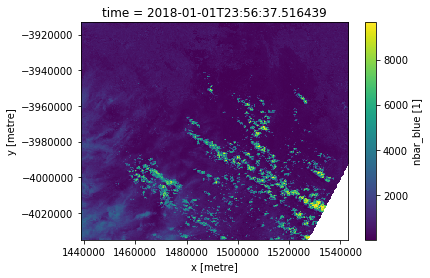

In [57]:
blue[0, ::10, ::10].plot.imshow();

In [58]:
from datacube.utils.geometry import GeoBox, Geometry, CRS

1/27" = 1 m
1/27 / 60 / 60 deg

In [59]:
DEGREES_PER_METER = 1 / (27 * 60 * 60)
DEGREES_PER_METER

1.02880658436214e-05

In [60]:
import numpy as np

In [61]:
from datacube.virtual.impl import reproject_array, reproject_band, compute_reproject_roi

In [62]:
from odc.algo import to_rgba

In [63]:
da = to_rgba(data, clamp=3000, bands=['nbart_red', 'nbart_green', 'nbart_blue'])

In [64]:
from collections.abc import Mapping

In [65]:
import xarray as xr

In [66]:
def reproject(ds, output_crs, output_res=None, resampling=None, dask_chunks=None):
    if isinstance(ds, xr.DataArray):
        return reproject_slice(ds, output_crs, output_res, resampling, dask_chunks)
    
    output_crs = CRS(output_crs)
    
    if output_res is None:
        if output_crs.units[0] not in CRS(ds.crs).units:
            raise ValueError
        else:
            output_res = ds.geobox.resolution

    output_geobox = GeoBox.from_geopolygon(ds.geobox.geographic_extent, resolution=output_res, crs=output_crs)
    
    output_bands = {}
    for band_name, band in ds.items():
        if hasattr(band.data, 'dask') and dask_chunks is None:
            dask_chunks = dict(zip(band.dims, band.data.chunksize))

        if isinstance(resampling, Mapping):
            band_resampling = resampling[band_name] if band_name in resampling else 'nearest'
        else:
            band_resampling = resampling
        output_bands[band_name] = reproject_band(band, output_geobox, resampling=band_resampling, dims=band.dims, dask_chunks=dask_chunks)
    
    return xr.Dataset(output_bands)

In [67]:
def reproject_da(da, output_crs, output_res=None, resampling=None, dask_chunks=None):
    output_crs = CRS(output_crs)
    
    if output_res is None:
        if output_crs.units[0] not in CRS(da.crs).units:
            raise ValueError
        else:
            output_res = da.geobox.resolution

    output_geobox = GeoBox.from_geopolygon(da.geobox.geographic_extent, resolution=output_res, crs=output_crs)
    
    if hasattr(da.data, 'dask') and dask_chunks is None:
        dask_chunks = dict(zip(da.dims, da.data.chunksize))
        
    if 'nodata' not in da.attrs:
        da.attrs['nodata'] = np.nan

    return reproject_band(da, output_geobox, resampling=resampling, dims=da.dims, dask_chunks=dask_chunks)

In [68]:
def reproject_slice(da, output_crs, output_res, resampling, dask_chunks):
    bad_dims = [dim for dim, dim_size in da.sizes.items() if dim not in ('x', 'y') and dim_size > 1]
    if bad_dims:
        dim_name = bad_dims[0]
        return xr.concat([reproject_slice(
            da.isel(**{dim_name:i}), output_crs, output_res, resampling, dask_chunks
                   ) for i in range(da[dim_name].size)], dim=dim_name).transpose(*da.dims)
    else:
        return reproject_da(da, output_crs, output_res, resampling, dask_chunks)

In [69]:
reprojected_data = reproject(da, 'epsg:3857', resampling='nearest')

In [70]:
da.load()

<xarray.DataArray 'ro_rgba-cc180561-9a1a643f96844d5f6e9a3b8850ecc132' (time: 1, y: 4062, x: 3473, band: 4)>
array([[[[212, 215, 208, 255],
         [208, 212, 205, 255],
         [198, 202, 200, 255],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]],

        [[213, 216, 209, 255],
         [208, 212, 205, 255],
         [197, 199, 198, 255],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]],

        [[216, 217, 210, 255],
         [210, 213, 206, 255],
         [194, 197, 203, 255],
         ...,
         [  0,   0,   0,   0],
         [  0,   0,   0,   0],
         [  0,   0,   0,   0]],

        ...,

        [[107, 101,  83, 255],
         [108,  99,  82, 255],
         [117, 106,  86, 255],
         ...,
         [ 68,  57,  36, 255],
         [ 73,  57,  36, 255],
         [ 74,  60,  37, 255]],

        [[116,  99,  82, 255],
         [127, 107,  88, 255],
         [133, 112,  90, 255],
         ...,
         [ 67,  57,  35, 255],
         [ 72,  57,  36, 255],
         [ 73,  57,  36, 255]],

        [[131, 112,  92, 255],
         [137, 114,  93, 255],
         [136, 115,  93, 255],
         ...,
         [ 71,  57,  36, 255],
         [ 72,  57,  36, 255],
         [ 70,  57,  36, 255]]]], dtype=uint8)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T23:56:37.516439
  * y        (y) float64 -4.035e+06 -4.035e+06 ... -3.913e+06 -3.913e+06
  * x        (x) float64 1.439e+06 1.439e+06 1.439e+06 ... 1.543e+06 1.543e+06
  * band     (band) <U1 'r' 'g' 'b' 'a'
Attributes:
    crs:      epsg:3577

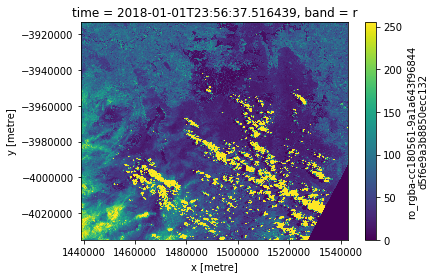

In [71]:
da[0, ..., 0].plot();